# Fine-tuning BERT for Sentiment Analysis
[![Portfolio](https://img.shields.io/badge/Portfolio-Aniruddha.github.io-blue?logo=GitHub)](https://github.com/aniruddhachoudhury/Artificial-Intelligence-Projects-)


# A - Introduction

A new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. BERT is designed to pre- train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be fine- tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task- specific architecture modifications.

One of the most biggest milestones in the evolution of NLP recently is the release of Google's BERT, which is described as the beginning of a new era in NLP. In this notebook I'll use the HuggingFace's `transformers` library to fine-tune pretrained BERT model for a classification task. Then I will compare the BERT's performance  with a baseline model, in which I use a TF-IDF vectorizer and a Naive Bayes classifier. The `transformers` library help us quickly and efficiently fine-tune the state-of-the-art BERT model and yield an accuracy rate **10%** higher than the baseline model.


*  It’s easy to get that BERT stands for Bidirectional Encoder Representations from Transformers. Each word here has a meaning to it and we will encounter that one by one. For now, the key takeaway from this line is — BERT is based on the Transformer architecture.

*   BERT is pre-trained on a large corpus of unlabelled text including the entire Wikipedia(that’s 2,500 million words!) and Book Corpus (800 million words). This pretraining step is really important for BERT’s success. This is because as we train a model on a large text corpus, our model starts to pick up the deeper and intimate understandings of how the language works. This knowledge is the swiss army knife that is useful for almost any NLP task.



*   BERT is a deeply bidirectional model. Bidirectional means that BERT learns information from both the left and the right side of a token’s context during the training phase.





**Reference**:

To understand **Transformer** (the architecture which BERT is built on) and learn how to implement BERT, I highly recommend reading the following sources:

- [The Illustrated BERT, ELMo, and co.](http://jalammar.github.io/illustrated-bert/): A very clear and well-written guide to understand BERT.
- [The documentation of the `transformers` library](https://huggingface.co/transformers/v2.2.0/index.html)
- [BERT Fine-Tuning Tutorial with PyTorch](http://mccormickml.com/2019/07/22/BERT-fine-tuning/): A very detailed tutorial showing how to use BERT with the HuggingFace PyTorch library.

- [Bert Architecture Explanation](https://blog.usejournal.com/part1-bert-for-advance-nlp-with-transformers-in-pytorch-357579d63512) by [Aniruddha Choudhury](https://www.linkedin.com/in/aniruddha-choudhury-5a34b511b/)



## A.1 Bert Model Architecture

![](https://miro.medium.com/max/2868/0*Hp91TFQUWqKWyta1)



*  BERT-Large, Uncased (Whole Word Masking): 24-layer, 1024-hidden, 16-heads, 340M parameters


*   BERT-Large, Cased (Whole Word Masking): 24-layer, 1024-hidden, 16-heads, 340M parameters

*  BERT-Base, Uncased: 12-layer, 768-hidden, 12-heads, 110M parameters
*   BERT-Large, Uncased: 24-layer, 1024-hidden, 16-heads, 340M parameters


*   BERT-Large, Uncased: 24-layer, 1024-hidden, 16-heads, 340M parameters



*   BERT-Base, Cased: 12-layer, 768-hidden, 12-heads , 110M parameters

*   BERT-Large, Cased: 24-layer, 1024-hidden, 16-heads, 340M parameters





# B - Setup

## 1. Load Essential Libraries

In [0]:
import os
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
import numpy as np
import pandas as pd
%matplotlib inline

## 2. Dataset

### 2.1. Download Dataset

In [0]:
# Download data
import requests
req = requests.get("https://drive.google.com/uc?export=download&id=1wHt8PsMLsfX5yNSqrt2fSTcb8LEiclcf")
with open("data.zip", "wb") as file:
    file.write(req.content)

# Unzip data
import zipfile
with zipfile.ZipFile('data.zip') as zip:
    zip.extractall('data')

### 2.2 Loading Train  & Test Data and splitting the data 

So the training  data contains 2 files, each one containing 1700 complaints/non-complaining tweets so we can say our data is balanced. Each every tweets in our data of airline contains at least a hashtag for each row.So after loading the training data,here we required the text data for the classification analysis so we will drop the non-importance columns & kept the label, Tweet ,Id columns in the required table.

In [3]:
 # Load the data and set the respective  labels
data_comp = pd.read_csv('data/complaint1700.csv')
data_non_comp = pd.read_csv('data/noncomplaint1700.csv')

data_comp['label'] = 0
data_non_comp['label'] = 1

# Concatenate the  complaining and non-complaining data
data = pd.concat([data_comp, data_non_comp], axis=0).reset_index(drop=True)

# Drop the 'airline' column which is not required
data.drop(['airline'], inplace=True, axis=1)

# Display 5 random samples
data.sample(5)

,id,tweet,label
3203,151165,May The 4th Be With Uou Late Post... JetBlue S...,1
3215,151675,CANNOT WAIT to try this inflight! Amazon Prime...,1
1688,161537,Just curious @SouthwestAir why you announce 15...,0
1568,172527,Never going to book a flight with @united unti...,0
1367,86862,I bought maze runner on my @SouthwestAir fligh...,0


We will randomly split the entire training data into two sets: a train set with 90% of the data and a validation set with 10% of the data. We will perform hyperparameter tuning using cross-validation on the train set and use the validation set to compare models.

In [0]:
from sklearn.model_selection import train_test_split

X = data.tweet.values
y = data.label.values

X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.1, random_state=2020)

### 2.3. Uploading the Test Data
The test data contains 4555 examples with no label. About 300 examples are non-complaining tweets. Our task is to identify their `id` and examine manually whether our results are correct.

In [5]:
# Load test data
test_data = pd.read_csv('data/test_data.csv')

# Keep important columns
test_data = test_data[['id', 'tweet']]

# Display 5 samples from the test data
test_data.sample(5)

,id,tweet
356,14162,@DeltaAssist on tarmac going on 40 minutes DL5...
2938,111849,Flight LGA/BOS cancelled due to weather. Reboo...
270,10228,@united I have for 4+ weeks with no response. ...
1196,46732,"@SouthwestAir How about a rewards program, lin..."
118,4746,Prayers goes out to all of they're family _ _@...


## 3. Setting up of GPU in Google Cloud

Google Colab offers free GPUs and TPUs. So we going to  training a large neural we will use these computational power 
 GPU can be selected from the following:
`Runtime -> Change runtime type -> Hardware accelerator: GPU`

In [6]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'Here the number of {torch.cuda.device_count()} GPU(s) available.')
    print('So the Device name:', torch.cuda.get_device_name(0))

else:
    print('Use CPU instead as No GPU ia available')
    device = torch.device("cpu")

Here the number of 1 GPU(s) available.
So the Device name: Tesla K80


# C - Baseline: TF-IDF + Naive Bayes Classifier

In this baseline approach, first we will use TF-IDF to vectorize our text data. Then we will use the Naive Bayes model as our classifier.

Why Naive Bayse? I have experiemented different machine learning algorithms including Random Forest, Support Vectors Machine, XGBoost and observed that Naive Bayes yields the best performance. In [Scikit-learn's guide](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) to choose the right estimator, it is also suggested that Naive Bayes should be used for text data. I also tried using SVD to reduce dimensionality; however, it did not yield a better performance.

## 1. Data Preparation

### 1.1. Preprocessing

In the bag-of-words model, a text is represented as the bag of its words, disregarding grammar and word order. Therefore, we will want to remove stop words, punctuations and characters that don't contribute much to the sentence's meaning.

In [7]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def datatext_preprocessing(x):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    x = x.lower()
    # Change 't to 'not'
    x = re.sub(r"\'t", " not", x)
    # Remove some special characters
    x = re.sub(r'([\;\:\|•«\n])', ' ', x)
    
    # Isolate and remove punctuations except '?'
    x = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', x)
    x = re.sub(r'[^\w\s\?]', ' ', x)
    # Remove @name
    x = re.sub(r'(@.*?)[\s]', ' ', x)
    
    # Remove stopwords except 'not' and 'can'
    x = " ".join([word for word in x.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    x = re.sub(r'\s+', ' ', x).strip()
    
    return x

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1.2. TF-IDF Vectorizer

In information retrieval, **TF-IDF**, short for **term frequency–inverse document frequency**, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. We will use TF-IDF to vectorize our text data before feeding them to machine learning algorithms.

In [8]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_cleaned = np.array([datatext_preprocessing(text_data) for text_data in X_train])
X_test_cleaned = np.array([datatext_preprocessing(text_data) for text_data in X_test])

# Calculate TF-IDF
TF_IDF= TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_TF = TF_IDF.fit_transform(X_train_cleaned)
X_test_TF = TF_IDF.transform(X_test_cleaned)

CPU times: user 8.84 s, sys: 942 ms, total: 9.78 s
Wall time: 9.83 s


## 2. Train Naive Bayes Classifier

### 2.1. Hyperparameter Tuning

Here we will apply AUC score & cross-validation to tune the required hyperparameters of our model. That function AUC_CV will return the average AUC score from cross-validation.



In [0]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def AUC_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_TF, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

The `MultinominalNB` class only have one hypterparameter - **alpha**. The code below will help us find the alpha value that gives us the highest CV AUC score.

So the best model alpha:  1.6


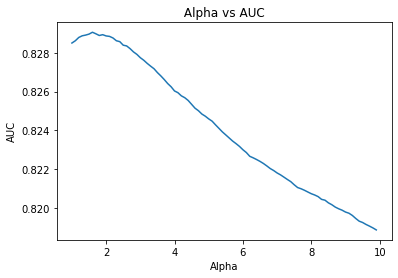

In [10]:
from sklearn.naive_bayes import MultinomialNB

result = pd.Series([AUC_CV(MultinomialNB(i))
                 for i in np.arange(1, 10, 0.1)],
                index=np.arange(1, 10, 0.1))

alpha_best = np.round(result.idxmax(), 2)
print('So the best model alpha: ', alpha_best)

plt.plot(result)
plt.title(' Alpha vs AUC ')
plt.ylabel('AUC')
plt.xlabel('Alpha')
plt.show()

In [11]:
Residual=pd.DataFrame(result)
Residual.columns=['AUC']
Residual['Alpha']=Residual.index
Residual.reset_index(inplace=True,drop=True)
Residual.head()


,AUC,Alpha
0,0.828505,1.0
1,0.828623,1.1
2,0.828792,1.2
3,0.828877,1.3
4,0.828913,1.4


In [12]:
import plotly.express as px
print('Best alpha: ', alpha_best)
fig = px.line(Residual, x="Alpha", y="AUC", title='AUC Vs Alpha')
fig.show()

Best alpha:  1.6


### 2.2. Evaluation on Validation Set

To evaluate the performance of our model, we will calculate the accuracy rate and the AUC score of our model on the validation set.

In [0]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

By combining TF-IDF and the Naive Bayes algorithm, we achieve the accuracy rate of **75.59%** on the validation set. This value is the baseline performance and will be used to evaluate the performance of our fine-tune BERT model. 

AUC: 0.8412
Accuracy: 73.82%


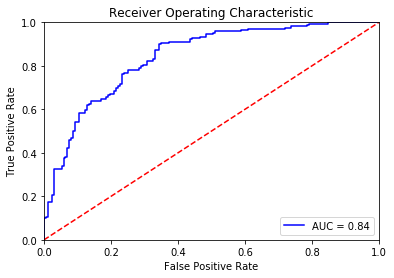

In [14]:

# So we calculated the predicted probabilities
naive_model = MultinomialNB(alpha=1.8)
naive_model.fit(X_train_TF, y_train)
probs = naive_model.predict_proba(X_test_TF)

# evaluation matrix done
evaluate_roc(probs, y_test)

In [0]:
import plotly.graph_objs as go
def roc_curve_naive(log_fpr, log_tpr):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=log_fpr, y=log_tpr,
                             fill=None,
                             mode='lines',
                             line_color='red',
                             name='Naive Bayes Classifier Score:'
                             ))
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1],
                             fill=None,
                             mode='lines', line={'dash': 'dash', 'color': 'black'},
                             name='Minimum ROC Score'
                            ))
    fig.update_layout( xaxis_title='False Positive Rate',
                      yaxis_title='True Positive Rate',
                    title={'text':'Logistic Regression ROC Curve',
                        'y':0.75,
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'},
             height=600, width=1000,
                     legend=dict(x=-.1, y=1.5))
    fig.show()
    
    


In [16]:
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')
       
# Get our accuracy over the test set
y_pred = np.where(preds >= 0.5, 1, 0)
accuracy = accuracy_score(y_test, y_pred)
print(f'So our for the Model is Accuracy: {accuracy*100:.2f}%')
roc_curve_naive(fpr,tpr)

AUC: 0.8412
So our for the Model is Accuracy: 73.82%


# D - Fine-tuning BERT

## 1. Install the Hugging Face Library

The transformer library of Hugging Face contains PyTorch implementation of state-of-the-art NLP models including BERT (from Google), GPT (from OpenAI) ... and pre-trained model weights.

In [17]:
# Uncomment the line below to install `transformers`
!pip install transformers

## 2. Tokenization and Input Formatting

Before tokenizing our text, we will perform some slight processing on our text including removing entity mentions (eg. @united) and some special character. The level of processing here is much less than in previous approachs because BERT was trained with the entire sentences.

In [0]:
def text_preprocessing(x):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    x = re.sub(r'(@.*?)[\s]', ' ', x)

    # Replace '&amp;' with '&'
    x = re.sub(r'&amp;', '&', x)

    # Remove trailing whitespace
    x = re.sub(r'\s+', ' ', x).strip()

    return x

In [22]:
# Print sentence random
print('Original: ', X[2])
print('Processed: ', text_preprocessing(X[2]))

Original:  Livid in Vegas, delayed, again&amp; again&amp;again, @SouthwestAir decided to cancel a flight and combine two, then waited on crew, now pilots.
Processed:  Livid in Vegas, delayed, again& again&again, decided to cancel a flight and combine two, then waited on crew, now pilots.


### 2.1. BERT Tokenizer

In order to apply the pre-trained BERT, we must use the tokenizer provided by the library. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

In addition, we are required to add special tokens to the start and end of each sentence, pad & truncate all sentences to a single constant length, and explicitly specify what are padding tokens with the "attention mask".

The `encode_plus` method of BERT tokenizer will:

(1) split our text into tokens,

(2) add the special `[CLS]` and `[SEP]` tokens, and

(3) convert these tokens into indexes of the tokenizer vocabulary,

(4) pad or truncate sentences to max length, and

(5) create attention mask.






In [0]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def Bert_preprocessing(x):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in x:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Before tokenizing, we need to specify the maximum length of our sentences.

In [24]:
# Concatenate train data & the test data
Total_tweets = np.concatenate([data.tweet.values, test_data.tweet.values])

# So we the encoded our concatenated data
Transformed_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in Total_tweets]

# To ind the maximum length
Maximum_len = max([len(sent) for sent in Transformed_tweets])
print('So the Max length here is: ', Maximum_len)

So the Max length here is:  68


Now let's tokenize our data.

In [25]:
# Specify `MAX_LEN`
MAX_LEN = 68

# Print sentence 0 and its encoded token ids
Token_ID = list(Bert_preprocessing([X[0]])[0].squeeze().numpy())
print('Original: ', X[1])
print('Token IDs: ', Token_ID)

# We went to run the function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
Train_IP, Train_Msks = Bert_preprocessing(X_train)
Test_IP, Test_Msks = Bert_preprocessing(X_test)

Original:  @united kinda feel like the $6.99 you charge for in flight Wi-Fi is ridiculous. AND it sucks, slow, or doesn't work. #anythingtomakeabuck
Token IDs:  [101, 1045, 1005, 1049, 2383, 3314, 1012, 7483, 1045, 2128, 8654, 2098, 2005, 2484, 2847, 2044, 1045, 2001, 4011, 2000, 4875, 1010, 2085, 1045, 2064, 1005, 1056, 8833, 2006, 1004, 4638, 1999, 1012, 2064, 2017, 2393, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


### 2.2. Create PyTorch DataLoader

For the next step of instance here we going to create an iterator for our dataset which will be using  the class Data Loader in pytorch. So this going to help us to  save on memory during training &  it will boost the training speed.

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
Train_Tar = torch.tensor(y_train)
Test_Tar = torch.tensor(y_test)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
Batch_Size = 32

# Create the DataLoader for our training set
Train_Data = TensorDataset(Train_IP, Train_Msks, Train_Tar)
Train_Sampler = RandomSampler(Train_Data)
Train_Dataloader = DataLoader(Train_Data, sampler=Train_Sampler, batch_size=Batch_Size)

# Create the DataLoader for our validation set
Test_Data = TensorDataset(Test_IP,Test_Msks, Test_Tar)
Test_Sampler = SequentialSampler(Test_Data)
Test_Dataloader = DataLoader(Test_Data, sampler=Test_Sampler, batch_size=Batch_Size)

## 3. Train Our Model

### 3.1. Create BertClassifier

BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) on the output. The output of the final transformer layer of the `[CLS]` token is used as the features of the sequence to feed a classifier.

The `transformers` library has the [`BertForSequenceClassification`](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification) class which is designed for classification tasks. However, we will create a new class so we can specify our own choice of classifiers.

Below we will create a BertClassifier class with a BERT model to extract the last hidden layer of the `[CLS]` token and a single-hidden-layer feed-forward neural network as our classifier.

In [27]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# We will create the BertClassfier class with Forward Function
class BertClassificationModel(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassificationModel, self).__init__()
        # Here we going to Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Next turn is to Instantiate the  BERT model 
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # For the last layer we going to Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # At last we will Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Next we will Feed input data to the BERT Model & the classifier to compute logits.
        
        @param    attention_mask (torch.Tensor) function: The attention mask hold the
                      information for the shape (batch_size, max_length)
        @return   logits (torch.Tensor) function: In an output tensor the shape (batch_size,
                      num_labels)
        @param    input_ids (torch.Tensor) function: So the  input tensor got a  shape (batch_size,
                      max_length)              
        """
        #  Input Data will be feeded  to BERT Model
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Next is to Extract the last hidden state of  token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Then Feed input data to the classifier to compute required logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 56 µs, sys: 0 ns, total: 56 µs
Wall time: 60.6 µs


### 3.2. Optimizer & Learning Rate Scheduler

We created an optimizer to fine-tune our Bert Classifier Mode,. We recommend the following hyper-parameters:
* •	So the Batch size: 16/32/64/128
* •	Different types ofLearning rate (Adam/Momentum/): 5e-5, 3e-5 or 2e-5
* •	The Number of epochs to train the data in iteration: 2, 3, 4.5

Huggingface provided the [run_glue.py](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109) script, an examples of implementing the `transformers` library. In the script, the AdamW optimizer is used.

In [0]:
from transformers import AdamW, get_linear_schedule_with_warmup

def Model_Run(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassificationModel(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(Train_Dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

### 3.3. Training Loop

We going to  train our Bert Classifier for 4 epochs. In each respective epoch, we going to train our model & evaluation of  its performance done on test set. In more details, we will:



Training Model:
* •	First we going to unzip our data from dataloader & on GPU data is being loaded.
* •	So whatever the gradients calculated in previous steps was made Zero out
* •	Next we will perform a forward network to compute loss and logits
* •	To calulate gradients we will perform backward pass.
* •	Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
* •	Next turn we will update our model's parameters & Learning Rate.

Evaluation on Model:
* Next we going to unpacked  our data & on GPU data is being loaded.
*   We will perform a Forward pass for which we going to calculate accuracy rate & loss over the Test set.


In [0]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def seed_schedule(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def Model_Training(model, train_dataloader, test_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Test Loss':^10} | {'Test Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            Test_loss, Test_accuracy = Model_Evaluation(model, test_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {Test_loss:^10.6f} | {Test_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training for Bert Model is completed!")


def Model_Evaluation(model, Test_Dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    test_accuracy = []
    test_loss = []

    # For each batch in our validation set...
    for batch in Test_Dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        test_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        test_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    test_loss = np.mean(test_loss)
    test_accuracy = np.mean(test_accuracy)

    return test_loss, test_accuracy

Now, let's start training our BertClassifier!

In [32]:
seed_schedule(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = Model_Run(epochs=4)
Model_Training(bert_classifier, Train_Dataloader, Test_Dataloader, epochs=4, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  | Test Loss  | Test Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.639923   |     -      |     -     |   15.67  
   1    |   40    |   0.490758   |     -      |     -     |   15.09  
   1    |   60    |   0.499809   |     -      |     -     |   15.15  
   1    |   80    |   0.495407   |     -      |     -     |   15.21  
   1    |   95    |   0.498036   |     -      |     -     |   11.20  
----------------------------------------------------------------------
   1    |    -    |   0.527379   |  0.445893  |   78.47   |   75.04  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Test Loss  | Test Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.286744   |     -      |     -     |   16.00  
   2    |   40    |   0.294079   |     -      |     -     |   15.

### 3.4. Evaluation on Validation Set

In [0]:
import torch.nn.functional as F

def prediction_Bert(model, test_dataloader):
    """We Performd a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [0]:
import plotly.graph_objs as go
def bert_roc_curve(log_fpr, log_tpr):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=log_fpr, y=log_tpr,
                             fill=None,
                             mode='lines',
                             line_color='red',
                             name='BERT Model'
                             ))
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1],
                             fill=None,
                             mode='lines', line={'dash': 'dash', 'color': 'black'},
                             name='Minimum ROC Score'
                            ))
    
    fig.update_layout( xaxis_title='False Positive Rate',
                      yaxis_title='True Positive Rate',
                    title={'text':'Logistic Regression ROC Curve',
                        'y':0.75,
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'},
             height=600, width=1000,
                     legend=dict(x=-.1, y=1.5))
    fig.show()
    
    


AUC: 0.8790
Accuracy: 80.00%


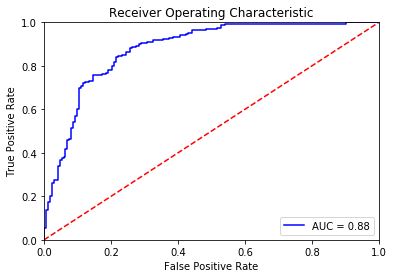

In [35]:
# Compute predicted probabilities on the test set
# Please initialize function `bert_predict` by running the first cell in Section 4.2.
probs = prediction_Bert(bert_classifier, Test_Dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_test)

In [36]:
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')
       
# Get accuracy over the test set
y_pred = np.where(preds >= 0.5, 1, 0)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')
bert_roc_curve(fpr,tpr)

AUC: 0.8790
Accuracy: 80.00%


The Bert Classifer achieves 0.90 AUC score and 80.65% accuracy rate on 
the validation set. This result is 10 points better than the baseline 
method. 

### 3.5. Train Our Model on the Entire Training Data

In [0]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, full_train_dataloader, epochs=2)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.673638   |     -      |     -     |   14.60  
   1    |   40    |   0.584607   |     -      |     -     |   13.95  
   1    |   60    |   0.519047   |     -      |     -     |   13.91  
   1    |   80    |   0.458444   |     -      |     -     |   13.92  
   1    |   100   |   0.453919   |     -      |     -     |   13.92  
   1    |   106   |   0.502116   |     -      |     -     |   3.74   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.320802   |     -      |     -     |   14.59  
   2    |   40    |   0.269877   |     -      |     -     |   13.88  
   2    |   60    |   0.284774   |     -      |     -     |   13.9

## 4. Predictions on Test Set

### 4.1. Data Preparation

Let's revisit out test set shortly.

In [0]:
test_data.sample(5)

Before making predictions on the test set, we need to redo processing and encoding steps done on the training data. Fortunately, we have written the `preprocessing_for_bert` function to do that for us.

In [0]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_data.tweet)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

### 4.2. Predictions

The prediction step is similar to the evaluation step that we did in the training loop, but simpler. We will perform a forward pass to compute logits and apply softmax to calculate probabilities.

In [0]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

There are about 300 non-negative tweets in our test set. Therefore, we will keep adjusting the decision threshold until we have about 300 non-negative tweets.

The threshold we will use is 0.90, meaning that tweets with a predicted probability greater than 90% will be predicted positive. This value is very high compared to the default 0.5 threshold.

After manually examining the test set, I realize that the sentiment classification task here is even difficult for human. Therefore, a high threshold will give us safe predictions.

In [0]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.90
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds.sum())

Number of tweets predicted non-negative:  473


Now we will examine 20 random tweets from our predictions. 17 of them are correct, the results showing that the BERT Classifier acquires about 0.85 precision rate.

In [0]:
output = test_data[preds==1]
list(output.sample(20).tweet)

["Woman With Kicked Off Flight By @AlaskaAir Because So Has #Cancer Plans to Donate Her Family's Airfare http://t.co/Uj6rispWLb",
 "Just flew @united the other day, but after reading about Tahera's experience, will switch to Delta. Can't believe this. #unitedfortahera",
 '@shaney852 @DeltaAssist @Delta no problems with @USAirways',
 'poor @alicewetterlund still just a bridesmaid... maybe she can use her @SouthwestAir savings on online dating.',
 'Waiting for that amazine call from @AmericanAir #NewAmerican for the vacancy in Cancun or Mexico',
 'Shoutout to the @SouthwestAir rep who saved me a seat on a later flight from #TPA _ #MSY in case my #FLL _ #TPA gets too delayed! ',
 'This plane smells like poop. @VirginAmerica',
 '@VirginAmerica Is the storm that bad or just taking precautions?',
 'Can hardly wait to see this little face in a few hours! Get me home, @virginamerica!  @ John F._ http://t.co/e6zgdi8tBQ',
 'Headed to Pensacola airport to attempt to return to Chicago. Counting on

# E - Conclusion

By adding a simple one-hidden-layer neural network classifier on top of BERT and fine-tuning BERT, we can achieve near state-of-the-art performance, which is 10 points better than the baseline method although we only have 3,400 data points.

In addition, although BERT is very large, complicated, and have millions of parameters, we only need to fine-tune it in only 2-4 epochs. That result can be achieved because BERT was trained on the huge amount and already encode a lot of information about our language. An impresive performance achieved in a short amount of time, with a small amount of data has shown why BERT is one of the most powerful NLP models available at the moment. 